In [8]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Descriptors import ExactMolWt
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import Draw
from IPython.display import display, Image
import io
from collections import Counter


In [9]:
# Some code to purge undesirable elements
def contains_undesirable_elements(smiles):
    undesirable_elements_list = ["Na", "K", "Ca", "Mg", "Cr", "B", "Si", "Ti", "Fe", "Al", "Co", "Zn", "Cu", "V", "Bi", "He", "P", "Cl", "Br", "F"]
    undesirable_smarts = [Chem.MolFromSmarts(f'[{element}]') for element in undesirable_elements_list]
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Warning: Could not parse SMILES: {smiles}")
        return True
    for i, smarts in enumerate(undesirable_smarts):
        if mol.HasSubstructMatch(smarts):
            #print(f"Match found: SMILES {smiles} contains {undesirable_elements_list[i]}")
            return True
    return False

# Some code to purge low label counts (<20)
def remove_low_count_columns(df, column_list, threshold=40):
    columns_to_remove = []
    for column in column_list:
        column_sum = df[column].sum()
        if column_sum < threshold:
            columns_to_remove.append(column)
            print(f"Removing column '{column}' with total count {column_sum}")
    
    df_filtered = df.drop(columns=columns_to_remove)
    if columns_to_remove == []:
        print(f"No columns are below count threshold {threshold}")
    return df_filtered

# Some code to purge large MWs or really small MWs

def visualize_molecule(smiles):
    # Convert SMILES to RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        # Generate a 2D depiction of the molecule
        img = Draw.MolToImage(mol)
        
        # Convert the image to bytes
        bio = io.BytesIO()
        img.save(bio, format='PNG')
        
        # Display the image
        display(Image(bio.getvalue()))
    else:
        print(f"Invalid SMILES: {smiles}")

def remove_molecular_weights(df, column_list, lower=20, higher=600):
    df['rdkit'] = df.apply(lambda row: Chem.MolFromSmiles(row['IsomericSMILES']), axis=1)
    df['mw'] = df.apply(lambda row: ExactMolWt(row['rdkit']), axis=1)

    print(f"Molecules below MW threshold {lower}: {len(df[df['mw'] < lower])}")
    for _, row in df[df['mw'] < lower].iterrows():
        positive_columns = [col for col in column_list if row[col] == 1]
        print(f"{row['IsomericSMILES']}, {', '.join(positive_columns)}")
        visualize_molecule(row['IsomericSMILES'])

    print(f"Molecules above MW threshold {higher}: {len(df[df['mw'] > higher])}")
    for _, row in df[df['mw'] > higher].iterrows():
        positive_columns = [col for col in column_list if row[col] == 1]
        print(f"{row['IsomericSMILES']}, {', '.join(positive_columns)}")
        visualize_molecule(row['IsomericSMILES'])
        
    df = df[(df['mw'] >= lower) & (df['mw'] <= higher)]
    return df

# Some code to purge salts or two-molecules-in-one-SMILES

def purge_salts_and_multimolecule(smiles):
    # Try to create an RDKit molecule from the SMILES
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        print(f"Invalid SMILES: {smiles}")
        return True
    
    # Check for multiple molecules
    if "." in smiles:
        print(f"{smiles} has multiple molecules")
        return True
    
    # Check for charges
    for atom in mol.GetAtoms():
        if atom.GetFormalCharge() != 0:
            print(f"{smiles} has charges")
            return True
    
    return False


Total undesirable element SMILES removed: 126
No columns are below count threshold 20
Molecules below MW threshold 20: 1
O, odorless


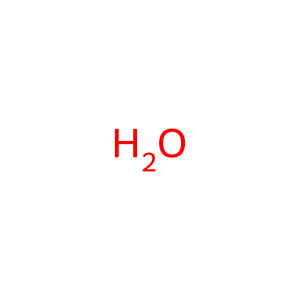

Molecules above MW threshold 9999: 0
C[N+](C)(C)[O-] has charges
COc1c(C(C)(C)C)cc([N+](=O)[O-])c(C)c1[N+](=O)[O-] has charges
CC(=O)[n+]1cc(C)nc(C)c1 has charges
CC(C)CC[N+](=O)[O-] has charges
[N-]=[N+]=O has charges
CC(=O)c1c(C)c([N+](=O)[O-])c(C(C)(C)C)c([N+](=O)[O-])c1C has charges
C1CNCCN1.O=C(O)CCCCC(=O)O has multiple molecules
C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12.O=S(=O)(O)O has multiple molecules
NC(CCC(=O)[O-])C(=O)O.[NH4+] has multiple molecules
N.N.O=S(=O)(O)O has multiple molecules
CC(=O)O.O=CC(O)C(O)C(O)C(O)CO has multiple molecules
O=C(O)c1ccccc1O.OCCN(CCO)CCO has multiple molecules
[NH4+].[NH4+].[S-2] has multiple molecules
C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12.C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12.O.O.O=S(=O)(O)O has multiple molecules
CC(C)CC(=O)O.N has multiple molecules
CCCCCCCCCCCCCCCCCCO.CCCCCCCCCCCCCCCCO has multiple molecules
Cc1c([N+](=O)[O-])c(C)c([N+](=O)[O-])c(C(C)(C)C)c1[N+](=O)[O-] has charges
Cc1c([N+](=O)[O-])cc2c(c1[N+](=O)[O-])C(C)(C)CC2(C)C has charg

In [10]:
df = pd.read_csv("gs-lf/curated_GS_LF_merged_4983.csv")

df.rename(columns={'nonStereoSMILES': "IsomericSMILES"}, inplace=True)

descriptor_list = df.columns[2:]

df['contains_undesirable_elements'] = df['IsomericSMILES'].apply(contains_undesirable_elements)
print(f"Total undesirable element SMILES removed: {len(df[df['contains_undesirable_elements'] == True])}")

df_filtered = df[~df['contains_undesirable_elements']].copy()

df_filtered = remove_low_count_columns(df=df_filtered, column_list=descriptor_list, threshold=20)

df_filtered = remove_molecular_weights(df=df_filtered, column_list=descriptor_list, lower=20, higher=9999)

df_filtered['salt_or_multimolecule'] = df_filtered['IsomericSMILES'].apply(purge_salts_and_multimolecule)
print(f"Total salts and multimolecules removed: {len(df_filtered[df_filtered['salt_or_multimolecule'] == True])}")

df_filtered = df_filtered[~df_filtered['salt_or_multimolecule']]

df_final = df_filtered.drop(columns=['contains_undesirable_elements', 'rdkit', 'mw', 'salt_or_multimolecule'])

df_final.to_csv("gs-lf/gs-lf_combined.csv", index=False)

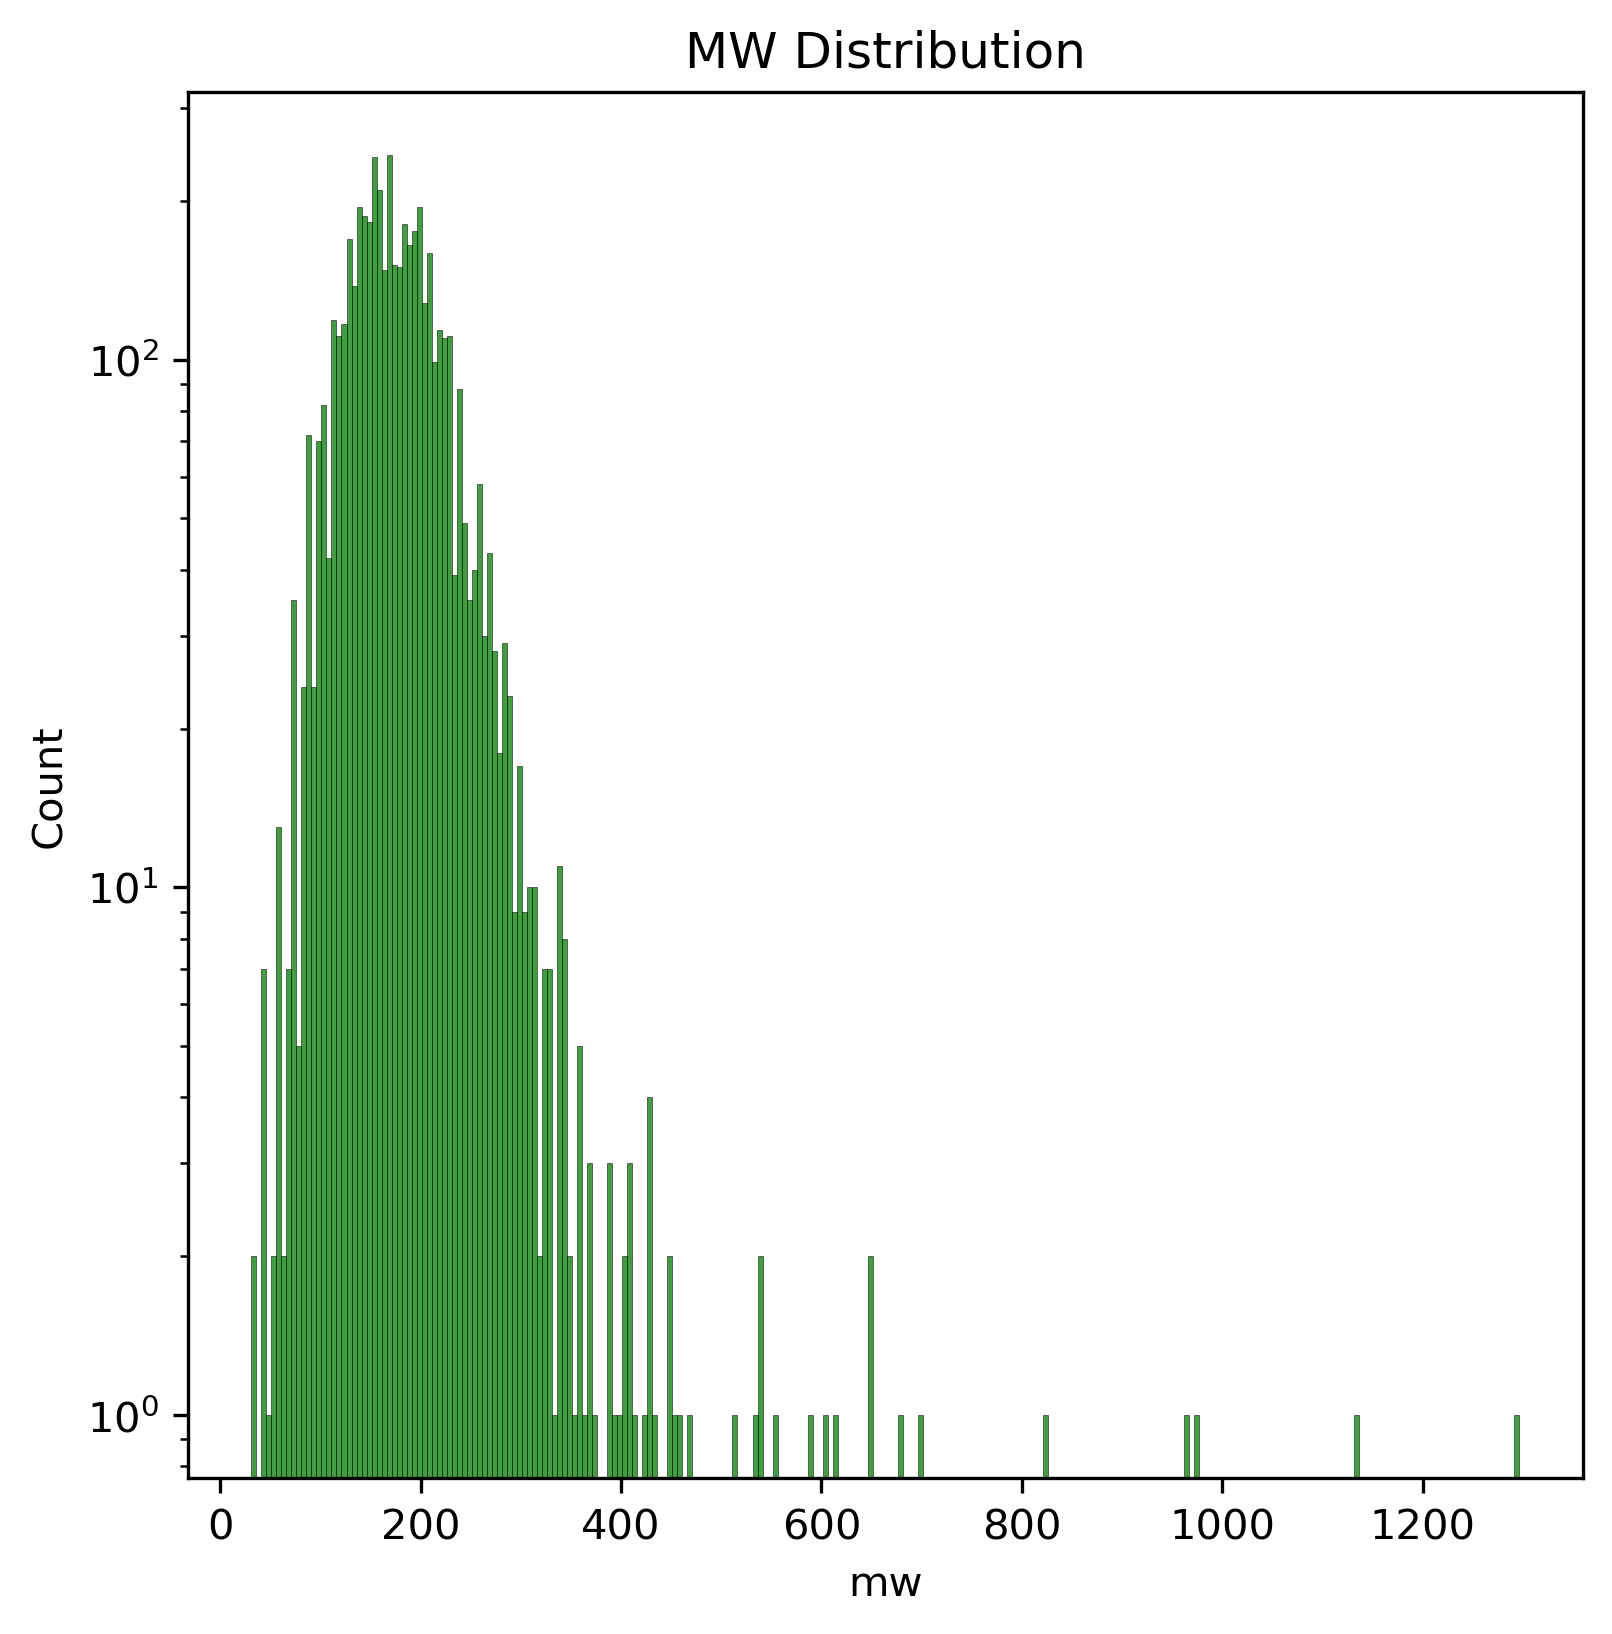

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
g = sns.histplot(df_filtered['mw'], ax=ax, binwidth=5, color='green')
ax.set_title("MW Distribution")
#ax.set_xlim([0,500])
g.set_yscale("log")
#ax.set_ylim([0, 100])

(1, 5000)

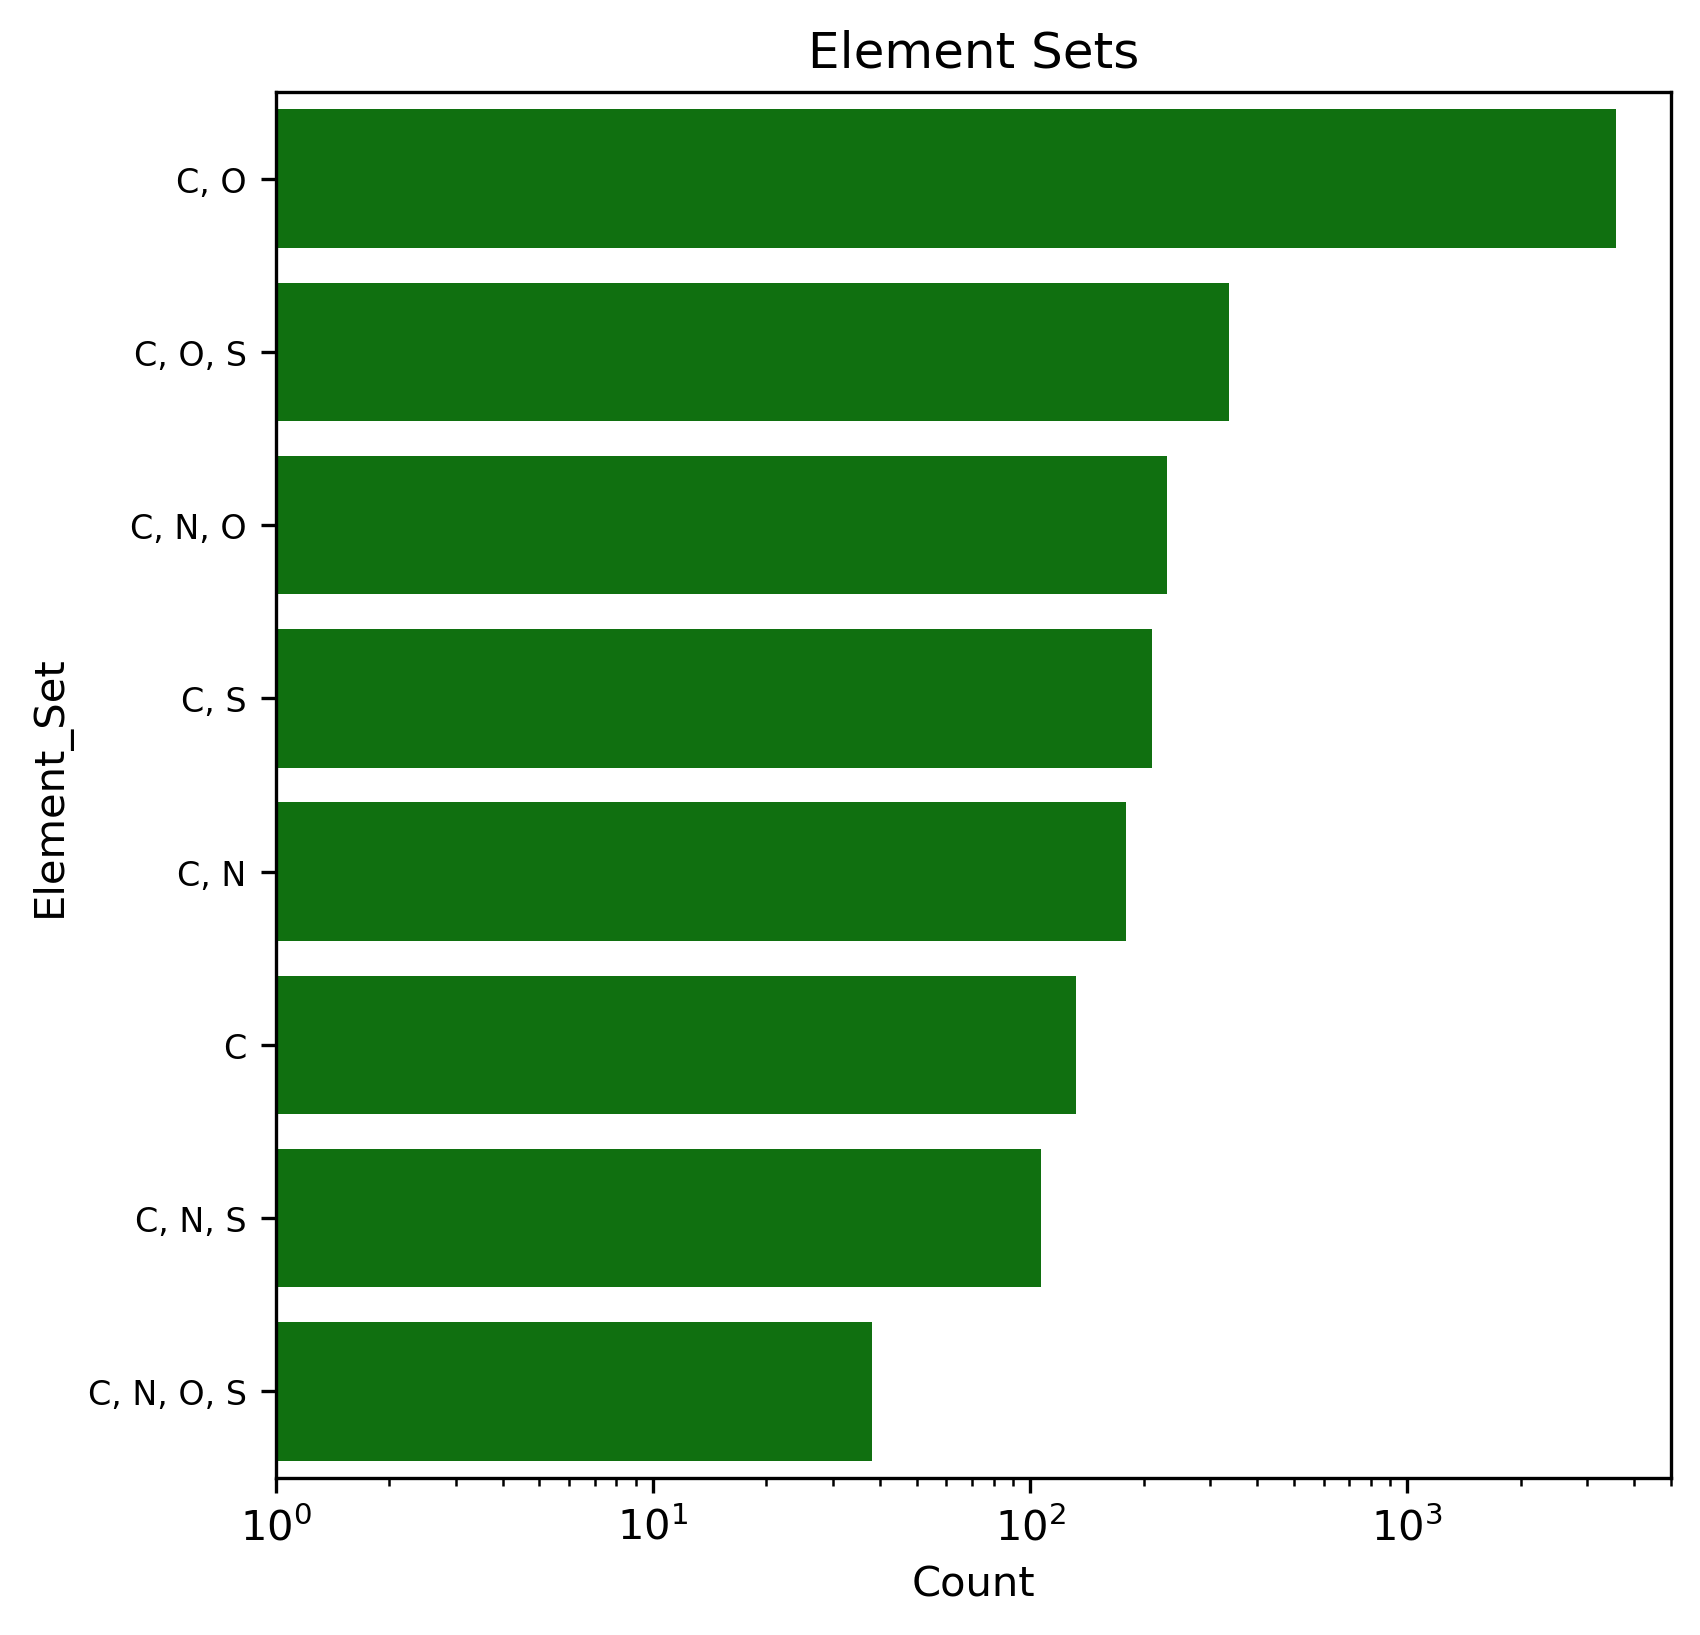

In [12]:
def get_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
        return tuple(sorted(elements))
    else:
        return []
    
df_filtered['Element_Sets'] = df_filtered['IsomericSMILES'].apply(get_elements)

# Create a Counter to count the occurrences of each set of elements
element_set_counts = Counter(df_filtered['Element_Sets'])

element_set_counts_df = pd.DataFrame(
    list(element_set_counts.items()), 
    columns=['Element_Set', 'Count']
)

# Convert tuple to string for better plotting
element_set_counts_df['Element_Set'] = element_set_counts_df['Element_Set'].apply(lambda x: ', '.join(x))

fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
g = sns.barplot(data=element_set_counts_df.sort_values('Count', ascending=False), y='Element_Set', x='Count', color='green', ax=ax, orient="h")

g.set_xscale("log")

ax.set_title("Element Sets")

# Rotate the x-axis labels for better readability
#plt.yticks(rotation=90, ha='center', size=6)
plt.yticks(size=8)

ax.set_xlim([1,5000])


In [13]:
df_final.shape

(4811, 140)